## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
from iminuit import Minuit

#import ROOT as r
#import warnings
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

## Section 1: including and visualizing 13 TeV dataset

In [4]:
xvalO = np.load("xvalO.npy")
yvalO = np.load("yvalO.npy")
xerrO = np.load("xerrO.npy")
xlowO = np.load("xlowO.npy")
xval = np.load("xval.npy")
yval = np.load("yval.npy")
xerr = np.load("xerr.npy")

toyList = np.load("toyList.npy")
lumiToDict = np.load("lumiToyList.npy")
meanGPnom = np.load("initialGPfit.npy")
fixedHyperparams = np.load("fixedHyperparams.npy")


### 4 parameters fit function

In [5]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  #1./(t/sqrts)


## Set up minimization. Look at GP and fit function background only fits to data, and GP and fit function signal+background fits to data+signal

### Calculate bin by bin significance
### calculate bin p value, convert to significance (z). If z is negative, set to 0. If bkg < data, make z negative

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                #pval = 1.-r.TMath.Gamma(nD+1.,nB)
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                #pval = pval = r.TMath.Gamma(nD,nB)
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                #zval = math.sqrt(2.)*r.TMath.ErfInverse(prob)
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
                #print "crap"
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2



def simpleLogPoisson(x, par):
    if x < 0: 
        #print "crap"
        return np.inf
    elif (x == 0): return -1.*par
    else:
        #lnpoisson = x*np.log(par)-par-r.TMath.LnGamma(x+1.)
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson
    
def makeToys(dataset, nPseudo=1000, lumi = 3.6):
    toys = []
    for n in range(nPseudo):
        pseudo = np.random.poisson(dataset*lumi/3.6)
        toys.append(pseudo)
    return toys

def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

In [18]:
#background only plots
def makePrettyPlots_chi2(GPchi2, BKGchi2, title, drawchi2=False, xname=r'$\chi^{2}$', label1 = "Gaussian Process", label2 = "Fit Function"):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
    f.suptitle(title, fontsize=30)

    lowx = min(min(GPchi2), min(BKGchi2))
    highx = max(max(GPchi2), max(BKGchi2))
    bins = np.linspace(lowx, highx, 200)
    
    '''
    hGP = Hist(200, lowx-1, highx+1,markersize=0)
    for chi2 in GPchi2:    
        hGP.Fill(chi2)
    hBKG = Hist(200, lowx-1, highx+1,markersize=0)
    for chi2 in BKGchi2:    
        hBKG.Fill(chi2)
        
    hGP.fillstyle = 'solid'
    hGP.fillcolor = 'green'
    hGP.linecolor = 'black'
    hGP.linewidth = 1
    hGP.Draw("histX0")
    gphist = rplt.bar(hGP, xerr=None, yerr=None, axes=ax1, label=label1)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    
    if drawchi2:
        xbins=[]
        ys =[]
        for i in range(hGP.GetNbinsX()):
            xbins.append(hGP.GetBinCenter(i))
            ys.append(hGP.GetBinContent(i))
        #chiPDF=5.*ss.chi2.pdf(xbins , 1)
        
        bf_params, bf_cov = op.curve_fit(ncchi, xbins, ys)
        print "nc, amp ", bf_params
        chiPDF = bf_params[1]*ss.ncx2.pdf(xbins, 1., bf_params[0])

        ax1.plot(xbins, chiPDF, c='r', linewidth=3)
    
    hBKG.fillstyle = 'solid'
    hBKG.fillcolor = 'blue'
    hBKG.linecolor = 'black'
    hBKG.linewidth = 1
    hBKG.Draw("histX0")
    bkghist = rplt.bar(hBKG, xerr=None, yerr=None, axes=ax2, label=label2)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    
    if drawchi2:
        xbins=[]
        ys=[]
        for i in range(hBKG.GetNbinsX()):
            xbins.append(hBKG.GetBinCenter(i))
            ys.append(hBKG.GetBinContent(i))
        #chiPDF=5.*ss.chi2.pdf(xbins , 1)
        
        bf_params, bf_cov = op.curve_fit(ncchi, xbins, ys)
        print "nc, amp ", bf_params
        chiPDF = bf_params[1]*ss.ncx2.pdf(xbins, 1., bf_params[0])
        
        ax2.plot(xbins, chiPDF, c='r', linewidth=3)
    
    
    '''


    hGP, _, _ =ax1.hist(GPchi2, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_title(label1, fontsize=20)
    
    hBKG, _, _ =ax2.hist(BKGchi2, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=20)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.set_xlabel(xname, fontsize=30)
    ax2.set_title(label2, fontsize=20)
    
    plt.show()



In [8]:
#background only plots
def makePrettyPlots_bkgFits(xs, ys, gpFits, bkgFits, title, ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, gpFits[ik], color='g', alpha = 0.3, linewidth=1.0, label="GP background only fit")
            bkgPlot_3, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="3 param only fit")
        else:
            bkgPlot =ax1.plot(xs, gpFits[ik], color='g', alpha = 0.3, linewidth=1.0)
            bkgPlot_3 =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


### Calculate NLL for fit function using poisson statistics - with or without signal. lnprob functions calls logLike function to calculate NLL.

In [9]:
class logLike_3ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    


class logLike_5ff:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2, p3, p4):
        params = p0, p1, p2, p3, p4
        bkgFunc = model_5param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin] 
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
    


### Minimize NLL of fit function.  fit functions call Minuit to minimize lnLike functions. Kick initial parameters, constrain parameters.  Minimize NLL of fit function with signal - add in signal strength parameter

In [23]:
def fit_3ff(lnprob, Print = True):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            if numRetries == 4: print "retry number = ", numRetries+1
            passedFit=True
        numRetries+=1
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs



def fit_5ff(lnprob, Print = True):
  #  np.random.seed(1234)
    bestval = np.inf
    bestargs = (0., 0., 0., 0., 0.)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        init3 = np.random.random() * 1.
        init4 = np.random.random() * 1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  p0 = init0, p1 = init1, p2 = init2, p3 = init3, p4 = init4,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, error_p3 = 1e-2, error_p4 = 1e-2,
                  limit_p0 = (0, 10), limit_p1 = (-20, 20), limit_p2 = (-20, 20), 
                   limit_p3 = (-20, 20), limit_p4 = (0, 50))
        fit = m.migrad()
        if fit[0]['is_valid']: 
            if numRetries == 4: print "retry number = ", numRetries+1
            passedFit=True
        numRetries+=1
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    if Print:
        print "min LL",bestval
        print "best fit vals", bestargs
    return bestval, bestargs


### Minimize NLL of GP using george lnlikelihood function - logLike functions calls gp.lnlikelihood to calculate NLL. 

### Minimize NLL of GP. call Minuit to minimize logLike functions. Kick initial parameters, constrain parameters. Minimize NLL of GP with signal - add in signal strength parameter

In [24]:
def model_gp(params, t, xerr=xerr): 
    #global xerr
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

def fit_gp_minuit(lnprob, Print = True):
    #np.random.seed(1234)
    bestval = np.inf
    bestargs = (0, 0, 0, 0, 0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 1e6+1
        init1 = np.random.random() * 400.
        init2 = np.random.random() * 10. 
        init3 = np.random.random() * -100.
        init4 = np.random.random() * 650.
        init5 = np.random.random() * 1.
        init6 = np.random.random() * 1.
        init7 = np.random.random() * -1.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef=0.5,
                  Amp = init0, decay = init1, length = init2, power = init3, sub = init4, 
                   p0 = init5, p1 = init6, p2 = init7,
                  error_Amp = 1, error_decay = 0.1, error_length = 0.1, error_power = 0.1, 
                   error_sub = 0.1, error_p0 = 1e-2, error_p1 = 1e-2, error_p2 = 1e-2,
                  limit_Amp = (1, 1e15), limit_decay = (0, 500), limit_length = (0, 200), 
                   limit_power = (-200, 200), limit_sub = (0, 1000), limit_p0 = (0,10), 
                   limit_p1 = (0, 10), limit_p2 = (-10,0)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            if numRetries == 4: print "retry number = ", numRetries+1
            passedFit=True
        numRetries+=1
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args 
    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs


class logLike_gp:
    def __init__(self, x, y, xerr):
        self.x = x
        self.y = y
        self.xerr = xerr
    def __call__(self, Amp, decay, length, power, sub, p0, p1, p2):
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf


In [12]:
def basicPlot(xs, ys, bkgs, title, col='g'):
    f, (ax1) = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="QCD MC")
    bkgPlot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="GP fit")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, 2e6])

In [25]:
print("Fitting gp only")


fitList = []
chi2BKGList =[]
GPList = []
chi2GPList = []
for itoy, toy in enumerate(toyList):
    if not itoy%100: print itoy
    lnProb = logLike_3ff(xvalO,toy,xerrO)
    bestval, best_fit_ff = fit_3ff(lnProb, False)
    bkg = model_3param(xvalO, best_fit_ff, xerrO)
    zvals, chi2 = calcSignificance(toy, bkg)
    chi2BKGList.append(chi2/(len(toy)-1-len(best_fit_ff)))
    fitList.append(bkg)
    
    ytoy, xtoy, xtoyerr = removeZeros(toy)
    if itoy == 0:
        lnProb = logLike_gp(xtoy,ytoy,xtoyerr)
        #Minimize, get best fit hyperparameters
        bestval, best_fit_gp = fit_gp_minuit(lnProb, False)
        Amp, decay, length, power, sub, p0, p1, p2 = best_fit_gp
        kernel = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d=sub)
        gp = george.GP(kernel)
        gp.compute(xtoy, np.sqrt(ytoy))
        meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)
    else:
        gp.compute(xtoy, np.sqrt(ytoy))
        meanGPp, covGP = gp.predict(ytoy - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
        meanGP = meanGPp+ model_3param(xvalO,(p0,p1,p2),xerrO)

    zvals, chi2 = calcSignificance(toy, meanGP)
    chi2GPList.append(chi2/(len(toy)-1-len(best_fit_gp)))
    GPList.append(meanGP)



Fitting gp only
0
100
200
300
400
500
600
700
800
900


## FIGURE 2 and 3

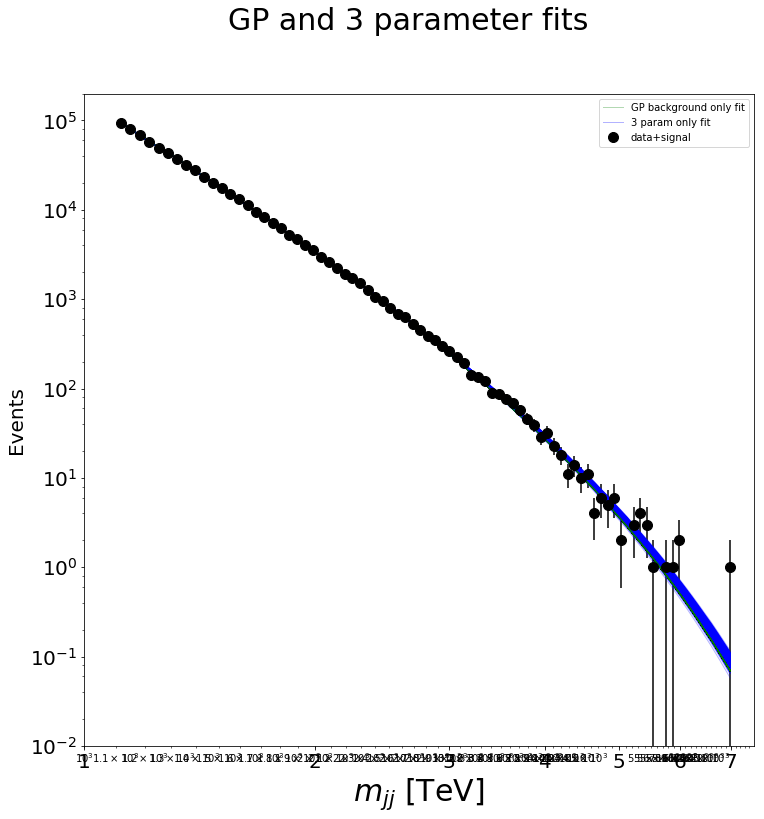

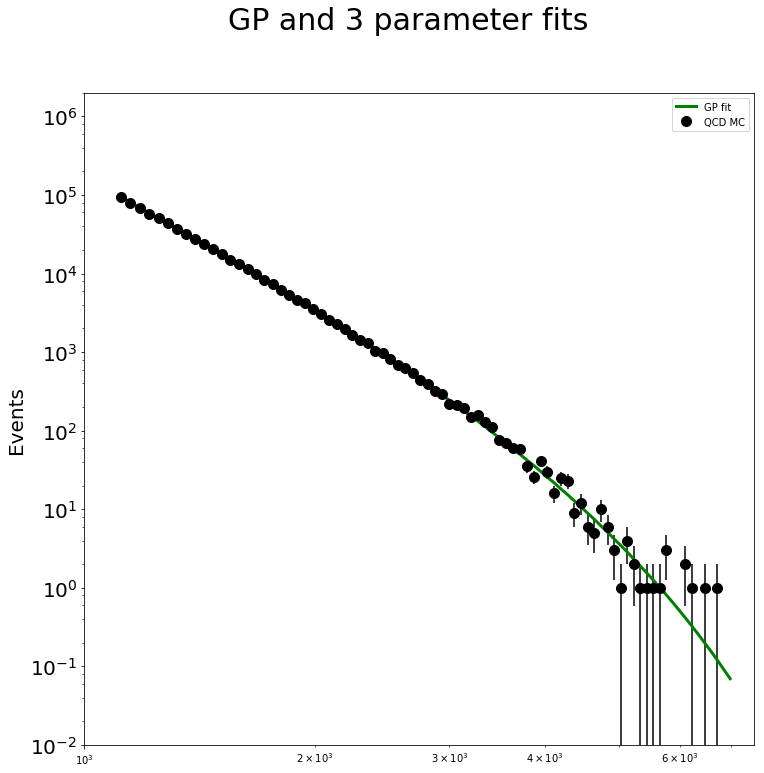

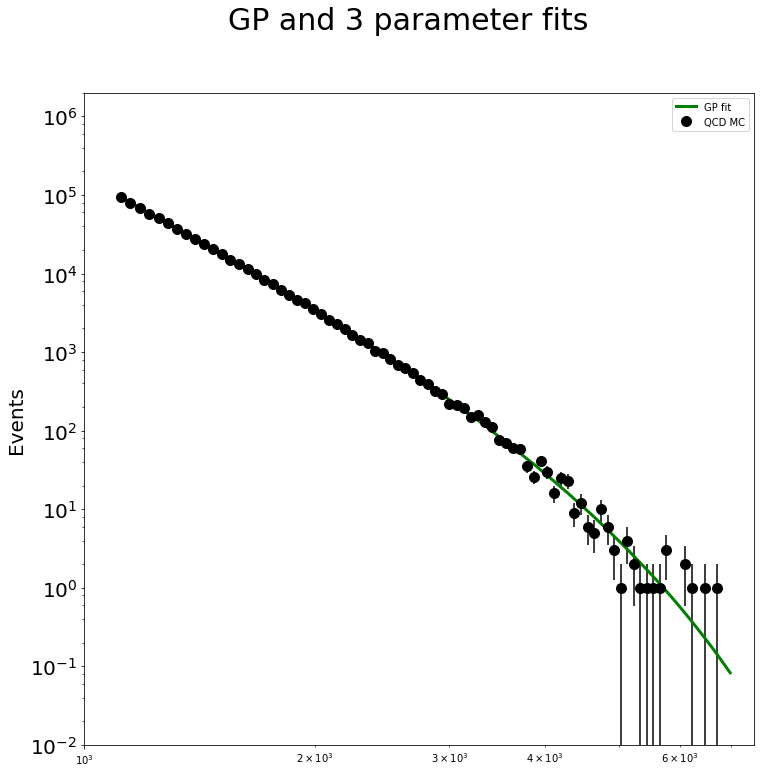

In [26]:
label = "GP and 3 parameter fits"
makePrettyPlots_bkgFits(xvalO, yvalO, GPList, fitList, label)
basicPlot(xvalO, toyList[0], GPList[0],  label)
basicPlot(xvalO, toyList[0], fitList[0],  label)
#makePrettyPlots(xvalO, toyList[0], GPList[0],  label)
#makePrettyPlots(xvalO, toyList[0], fitList[0],  label)

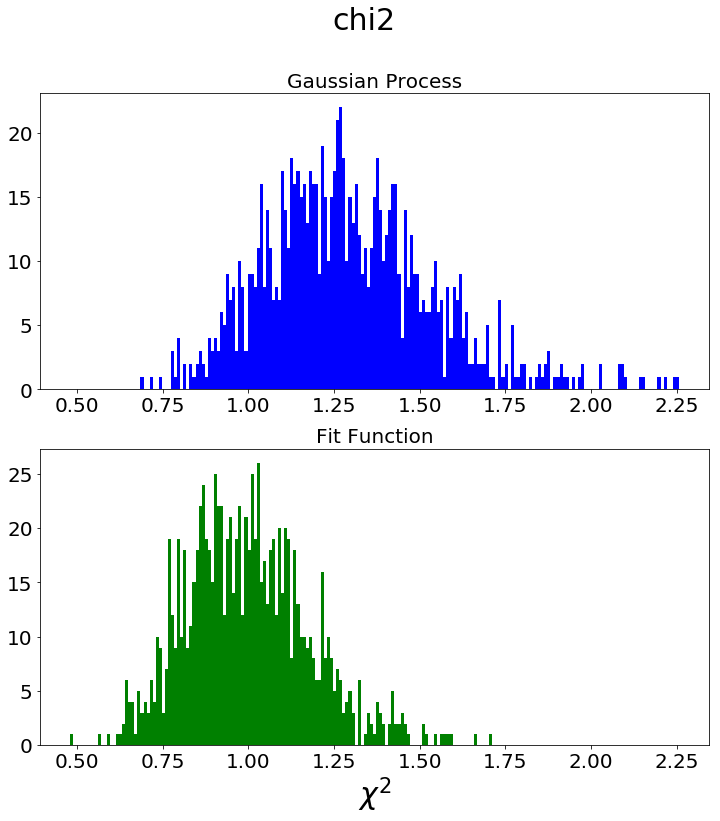

In [27]:
label = "chi2"
makePrettyPlots_chi2(chi2GPList, chi2BKGList, label)